In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm
import time

0.3149 seconds to run with 10 samples


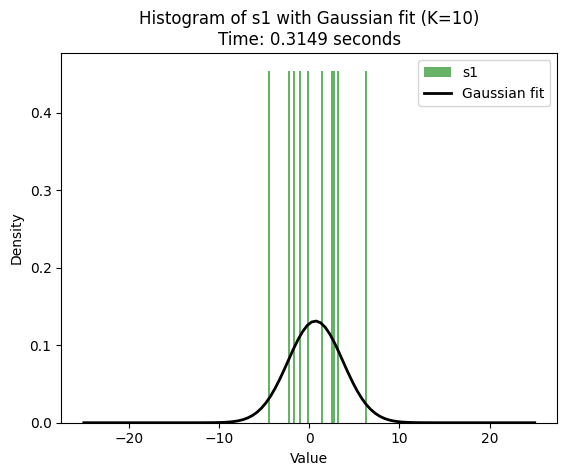

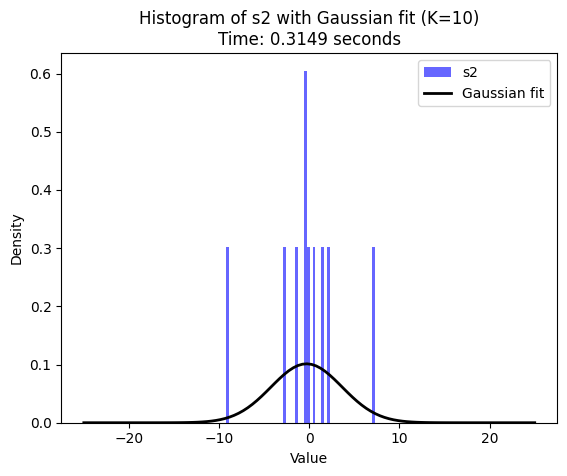

0.0720 seconds to run with 100 samples


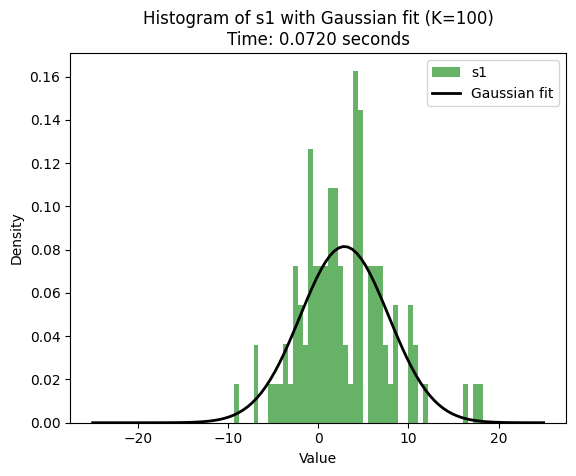

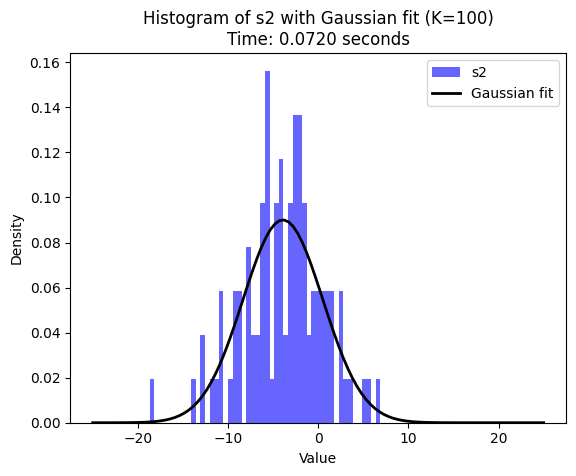

0.6961 seconds to run with 1000 samples


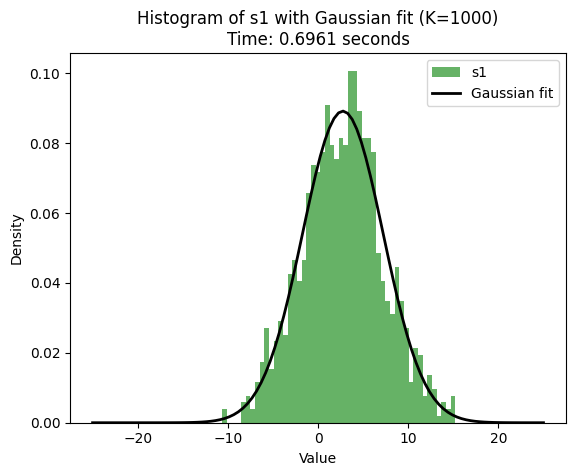

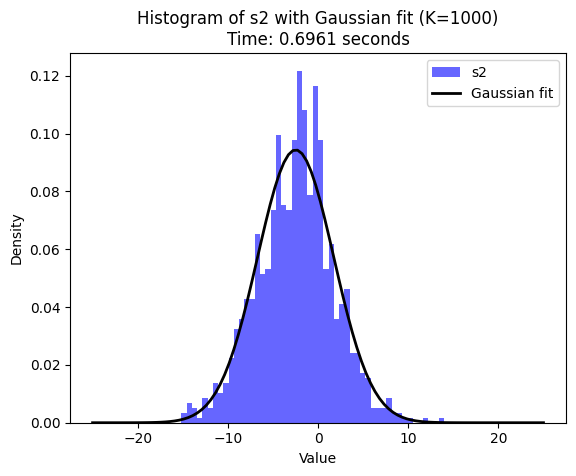

6.9944 seconds to run with 10000 samples


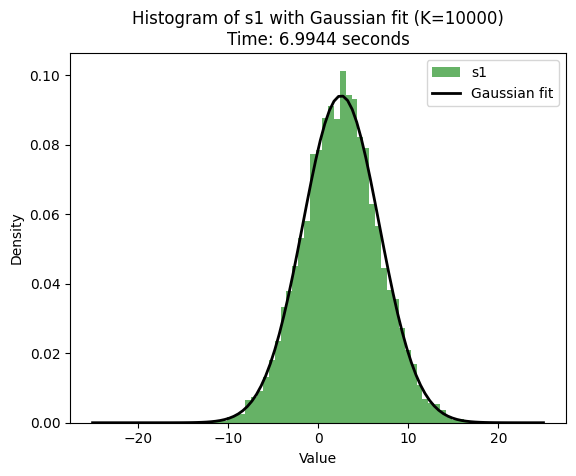

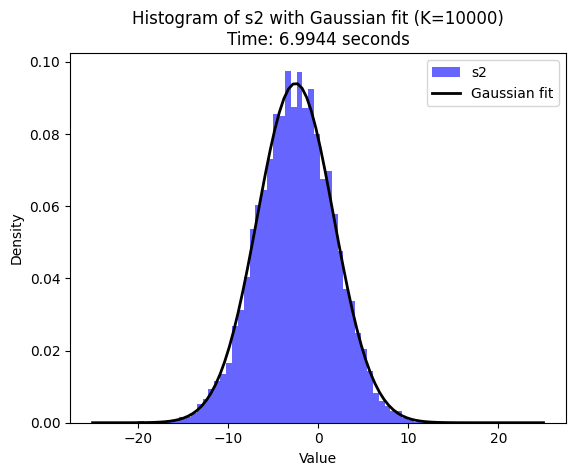

In [2]:
"""
Task 4

"""

def gibbs_sampling(mu1, sigma1, mu2, sigma2, K):
    """
    Perform Gibbs sampling to estimate posterior distributions.

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.
    K: Number of samples.

    Returns:
    s1, s2: Arrays of sampled values.
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    M = np.array([[1, -1]])
    sigma3 = 3

    mu = np.array([[mu1], [mu2]])  # Ensure mu is a column vector
    sigmaA = np.array([[sigma1**2, 0], [0, sigma2**2]])
    sigmaAB = np.linalg.inv(np.linalg.inv(sigmaA) + (1 / sigma3**2) * np.transpose(M) @ M)

    myclip_a = 0
    myclip_b = 1000
    my_std = sigma3

    # Gibbs sampling
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    s1[0] = mu1
    s2[0] = mu2

    for k in range(K-1):
        muAB = sigmaAB @ (np.linalg.inv(sigmaA) @ mu + (1 / sigma3**2) * np.transpose(M) @ np.array([[t[k]]]))
        muAB2 = np.ravel(muAB)  # Flatten the array to 1D
        s1[k+1], s2[k+1] = np.random.multivariate_normal(muAB2, sigmaAB)
        my_mean = s1[k+1] - s2[k+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[k+1] = truncnorm.rvs(a, b, loc=my_mean, scale=my_std)

    # Calculate parameters
    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)

    return s1, s2, mu_s1, std_s1, mu_s2, std_s2

def plot_histogram_and_fit(s1, s2, mu1, sigma1, mu2, sigma2, K, time_elapsed):
    # Parameters for plotting
    x_s1 = np.linspace(mu1 - 5 * sigma1, mu1 + 5 * sigma1, 100)
    x_s2 = np.linspace(mu2 - 5 * sigma2, mu2 + 5 * sigma2, 100)

    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    S1 = norm.pdf(x_s1, mu_s1, std_s1)

    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)
    S2 = norm.pdf(x_s2, mu_s2, std_s2)

    # Plot s1 histogram and Gaussian fit
    plt.hist(s1, bins=50, density=True, alpha=0.6, color='g', label="s1")
    plt.plot(x_s1, S1, 'k', linewidth=2, label="Gaussian fit")
    plt.title(f"Histogram of s1 with Gaussian fit (K={K})\nTime: {time_elapsed:.4f} seconds")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Plot s2 histogram and Gaussian fit
    plt.hist(s2, bins=50, density=True, alpha=0.6, color='b', label="s2")
    plt.plot(x_s2, S2, 'k', linewidth=2, label="Gaussian fit")
    plt.title(f"Histogram of s2 with Gaussian fit (K={K})\nTime: {time_elapsed:.4f} seconds")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Initial parameters
sigma1, sigma2, sigma3 = 5, 5, 3
mu1, mu2 = 0, 0

# Values of K to test
Ks = [10, 100, 1000, 10000]

for K in Ks:
    time_start = time.perf_counter()
    s1, s2, mu_s1, std_s1, mu_s2, std_s2 = gibbs_sampling(mu1, sigma1, mu2, sigma2, K)
    time_elapsed = time.perf_counter() - time_start
    print(f"{time_elapsed:.4f} seconds to run with {K} samples")
    plot_histogram_and_fit(s1, s2, mu1, sigma1, mu2, sigma2, K, time_elapsed)

In [3]:
"""
Task 5

"""


def gibbs_sampling_T5(mu1, sigma1, mu2, sigma2):
    """
    Wrapper function for gibbs_sampling to use a fixed number of samples (5000).

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.

    Returns:
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    K = 1000
    s1, s2, mu_s1, std_s1, mu_s2, std_s2 = gibbs_sampling(mu1, sigma1, mu2, sigma2, K)
    return (mu_s1, std_s1, mu_s2, std_s2)



def update_team_skills(data):
    """
    Update team skills based on match outcomes.

    Parameters:
    data: DataFrame containing match data.

    Returns:
    team_list: Dictionary with updated team skills.
    df: DataFrame with sorted team skills and ranks.
    """
    teams = data['team1'].drop_duplicates()
    team_list = {team: (0, 5) for team in teams}

    for i in range(data.shape[0]):
        score_diff = data.iloc[i]['score1'] - data.iloc[i]['score2']
        if score_diff != 0:
            winner = data.iloc[i]['team1'] if score_diff > 0 else data.iloc[i]['team2']
            loser = data.iloc[i]['team2'] if score_diff > 0 else data.iloc[i]['team1']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(
                team_list[winner][0], team_list[winner][1],
                team_list[loser][0], team_list[loser][1]
            )
            team_list[winner] = (mu1, sigma1)
            team_list[loser] = (mu2, sigma2)

    df = pd.DataFrame.from_dict(team_list, orient='index', columns=['Skill', 'Standard Deviation'])
    df.sort_values(by='Skill', ascending=False, inplace=True)
    df['Rank'] = range(1, len(df) + 1)

    return team_list, df

# Load data
data_shuffled = pd.read_csv("SerieA.csv").sample(frac=1).reset_index(drop=True)  # Shuffled data
data_unshuffled = pd.read_csv("SerieA.csv")  # Unshuffled data

# Update team skills for shuffled and unshuffled data
team_list_shuffled, df_shuffled = update_team_skills(data_shuffled)
team_list_unshuffled, df_unshuffled = update_team_skills(data_unshuffled)

# Print results
print("Shuffled Data Team List:\n", df_shuffled)
print("\nUnshuffled Data Team List:\n", df_unshuffled)

FileNotFoundError: [Errno 2] No such file or directory: 'SerieA.csv'

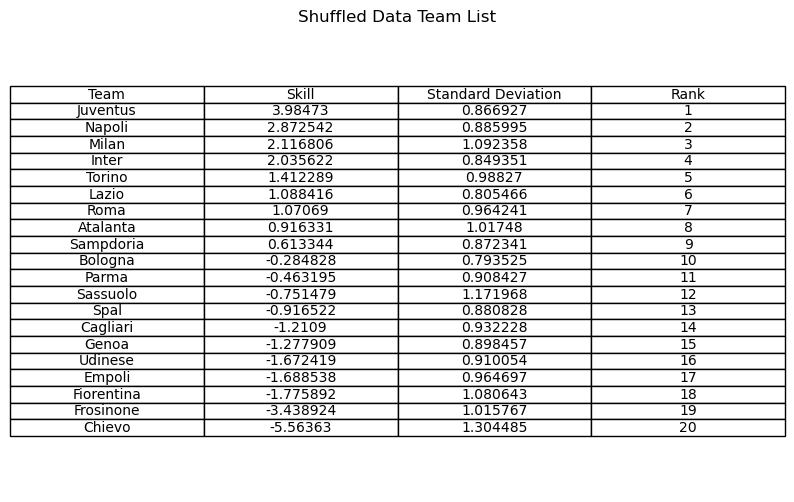

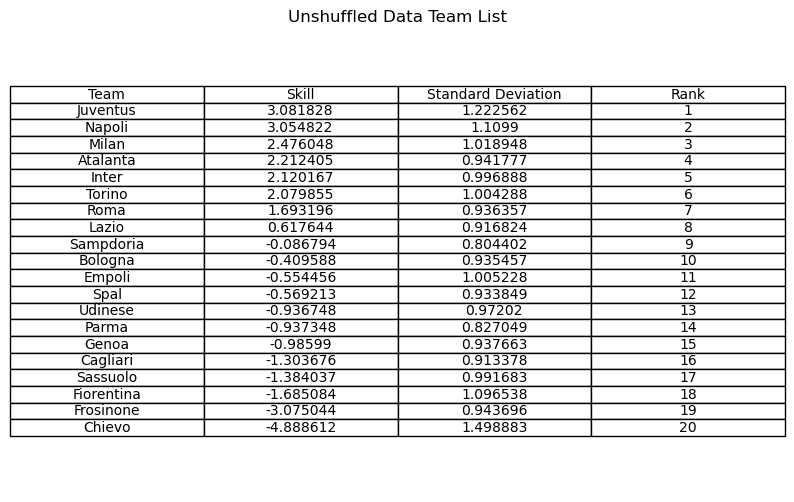

In [25]:
shuffled_data = {
    'Team': ['Juventus', 'Napoli', 'Milan', 'Inter', 'Torino', 'Lazio', 'Roma', 'Atalanta', 'Sampdoria', 'Bologna', 
             'Parma', 'Sassuolo', 'Spal', 'Cagliari', 'Genoa', 'Udinese', 'Empoli', 'Fiorentina', 'Frosinone', 'Chievo'],
    'Skill': [3.984730, 2.872542, 2.116806, 2.035622, 1.412289, 1.088416, 1.070690, 0.916331, 0.613344, -0.284828, 
              -0.463195, -0.751479, -0.916522, -1.210900, -1.277909, -1.672419, -1.688538, -1.775892, -3.438924, -5.563630],
    'Standard Deviation': [0.866927, 0.885995, 1.092358, 0.849351, 0.988270, 0.805466, 0.964241, 1.017480, 0.872341, 0.793525, 
                           0.908427, 1.171968, 0.880828, 0.932228, 0.898457, 0.910054, 0.964697, 1.080643, 1.015767, 1.304485],
    'Rank': list(range(1, 21))
}

# Define data for Unshuffled Data Team List
unshuffled_data = {
    'Team': ['Juventus', 'Napoli', 'Milan', 'Atalanta', 'Inter', 'Torino', 'Roma', 'Lazio', 'Sampdoria', 'Bologna', 
             'Empoli', 'Spal', 'Udinese', 'Parma', 'Genoa', 'Cagliari', 'Sassuolo', 'Fiorentina', 'Frosinone', 'Chievo'],
    'Skill': [3.081828, 3.054822, 2.476048, 2.212405, 2.120167, 2.079855, 1.693196, 0.617644, -0.086794, -0.409588, 
              -0.554456, -0.569213, -0.936748, -0.937348, -0.985990, -1.303676, -1.384037, -1.685084, -3.075044, -4.888612],
    'Standard Deviation': [1.222562, 1.109900, 1.018948, 0.941777, 0.996888, 1.004288, 0.936357, 0.916824, 0.804402, 0.935457, 
                           1.005228, 0.933849, 0.972020, 0.827049, 0.937663, 0.913378, 0.991683, 1.096538, 0.943696, 1.498883],
    'Rank': list(range(1, 21))
}

# Convert data to DataFrames
df_shuffled = pd.DataFrame(shuffled_data)
df_unshuffled = pd.DataFrame(unshuffled_data)

# Plot Shuffled Data Team List
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_shuffled.values, colLabels=df_shuffled.columns, cellLoc='center', loc='center')
plt.title('Shuffled Data Team List')
plt.savefig('shuffled_data_team_list.png', bbox_inches='tight')

# Plot Unshuffled Data Team List
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_unshuffled.values, colLabels=df_unshuffled.columns, cellLoc='center', loc='center')
plt.title('Unshuffled Data Team List')
plt.savefig('unshuffled_data_team_list.png', bbox_inches='tight')

plt.show()